## Proyecto tienda de videojuegos 
##Videogame Store project. 

## Preparacion de los datos 


Esp
En el primer paso se van a importar las librerias para el proyecto 

Eng
First we are going to import the libraries for the project. 

In [1]:
from scipy import stats as st
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
import math
import seaborn as sns


In [2]:
#Import the dataset
videogames =  pd.read_csv('games.csv')

ESP: Preparar y limpiar los datos 
ENG: Prepare and clean the data 

In [3]:
#checamos por valores faltantes y para tener una idea general del set. 
#we check for missing values and to get a general idea of the data set 
videogames.info(show_counts=True)


In [4]:
display (videogames.head(10))

ESP: Vemos que hay varios datos nullos en las resenias, asi mismo tenemos ratings como "undefined" 
Eng: We have several NaN data in the scores and also "undefined" on the ratings. 

In [5]:
#vamos a cambiar a minuscula todas las columnas 
#Lets change everything to lowercase 

videogames.columns = videogames.columns.str.lower()
#we are going to change the user_ score column to float since it is in object and we need to make calculations with it. 
#cambiar a float la columna de user score 
videogames['user_score'] = pd.to_numeric(videogames['user_score'],errors = 'coerce')

# we check for changes 
display (videogames.info(show_counts=True))

ESP:Hay varios valores que son "TBD" estos es que el dato eventualmente existira porque esta en desarrollo o no se ha calculado. Para propositos de este analisis esos datos se estan pasando a NaN 
ENG: We have several values as "TBD" since this mean the data would eventualy exist or is not calculated we are taking those as NaN 

Esp
Tratamiento de los valos Nan Por columna 
name: Hay 2 valores nulos en nombre de juego, estos son eliminados al no aportar ningun valor. 
Year of release: los juegos que tenian valores nulos en la columna de anio fueron eliminados. Esto debido a que solo representaban 269 juegos  es decir el 1.6 % de todos los datos lo cual es un valor aceptable para perder. Con acceso a otras bases de datos o una API externa se pudieron haber comparado y obtener sus valores poque si no la unica alternativa era introducirlos de forma manual. 
Genre: los valores nulos de Genre son los mismos que los de name asi que son eliminados. 
Ratings:En el caso de ratings los valores nulos los vamos a convertir a U de undefined, con acceso a la ESRB se podrian compaginar los datos pero eso se sale del scope de este analisis. 
Critic score y user_score: Primero vamos a poner ambos valores en la misma escala, user score esta en base 10 y critic score en base 100, el primer paso va a serigualar a base 100. Posteriorment en el caso de critic score y user score, cuando un valor es nulo pero el otro no vamos a igualar ambos valores. Cuando ambos valores esten faltantes se marcan como NaN y estos seran excluidos de analisis donde sea necesario que esten los valores.  

ENG
Threatment of NAn Values per column 
Name: There are those missing values in name, we are eliminating those are they do not offer relevant information and can be mistakes in the data base. 
Year of release: Games without year of releasa where eliminated. We want to make estimations for 2017 so we need to have the year of the games to compare it. There are 269 missing values which is 1.6% of the dataset which is an aceptable amount to loose. 
Genre:NaN values in genre where the same as Name 
Ratings: Rating values are going to be changed to U of undefined. If we had access to an ESRB Api we could potentially parse the document to check for their score if they exist but that is outside the scope of this project. 
Critic and user Score: First we are going to put the values on the same scale, user score is in base 10 and critic score on base 100, we are going to make both base 100. AFterwards when there is a missing score on one column but not on the other we ae going to equal both values. When both values are missing we are going to mark them down as NaN and exclude them from analysis where they are relevant. 

In [6]:
#Dropeamos todos los de nombre y anio de lanzamiento. 
#we drop name and year
videogames= videogames.dropna(subset=['name','year_of_release'])
#cambiamos en rating los nulos a Undef
#change rating to undef 
videogames['rating']= videogames['rating'].fillna('undefined')
#quitamos el valor tbd de critic y user score 
#remove the TBD from critic and user score 
videogames['critic_score'] = videogames['critic_score'] .replace('tbd', np.nan).astype(float)
videogames['user_score'] = videogames['user_score'] .replace('tbd', np.nan).astype(float)
#procedemos a multiplicar por 10 para dejar en base 100 
#multiply to get base 100 
videogames['user_score'] = videogames['user_score']*10

videogames['year_of_release'] = videogames['year_of_release'].astype(int)

#si los valores de critic score o user score solo tenemos uno se modifica usando el otro. 
#if we have one of the score we equal it. 
videogames['critic_score'] = videogames['critic_score'].fillna(videogames['user_score'])
videogames['user_score'] = videogames['user_score'].fillna(videogames['critic_score'])
#check on the data 
display (videogames.sample(10))
display (videogames.info(show_counts=True))

In [7]:
#checamos duplicados en esto caso debido a que muchos juegos salen en varias plataformas o anios se debe
#checar si son duplicados verdaderos comparando nombre, anio y plataforma. 
# we check for duplicated with the name, year and platform since multiplatform games could appear as duplicates if we use only one column




duplicatedcolumns = ['name', 'year_of_release','platform']
FilasDuplicadas = videogames[videogames.duplicated(subset=duplicatedcolumns, keep=False)]
display ((FilasDuplicadas))
#hay un dato duplicado asi que se elimina. 
# a single duplicated value that we drop. 
videogames = videogames.drop(16230)

In [8]:
#vamos a agregar una columna de ventas totales 
# we are adding a total sales column that adds the sales from the three regions. 

videogames['total_sales'] = videogames['na_sales']+videogames['eu_sales']+videogames['jp_sales']+videogames['other_sales']



# Primer ronda de analisis
# First round of analysis 

ESP:  Primero vamos a ver cuantos juegos se lanzan cada anio. 
Eng: We first see how many games we are releasing per year.

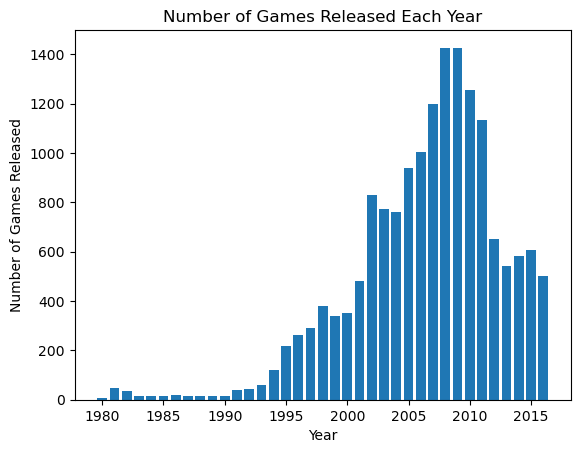

In [9]:
videogamesLaunchedPerYear = videogames.groupby ('year_of_release')['name'].count().reset_index()

videogamesLaunchedPerYear.rename(columns={'name':'games_released'}, inplace =True)



plt.bar(videogamesLaunchedPerYear['year_of_release'], videogamesLaunchedPerYear['games_released'])
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released Each Year')
plt.show()





ESP: Vemos que el numero de juegos ha aumentado entre 2005 y 2010, esto puede deberse a factores como proliferacion de consolas, o exceso de shovelware 
#ENG: We see that the numbr of games have spiked between 2005 and 2010, this could be from proliferation of sales, better data recollection from those years or excess of shovelware. 

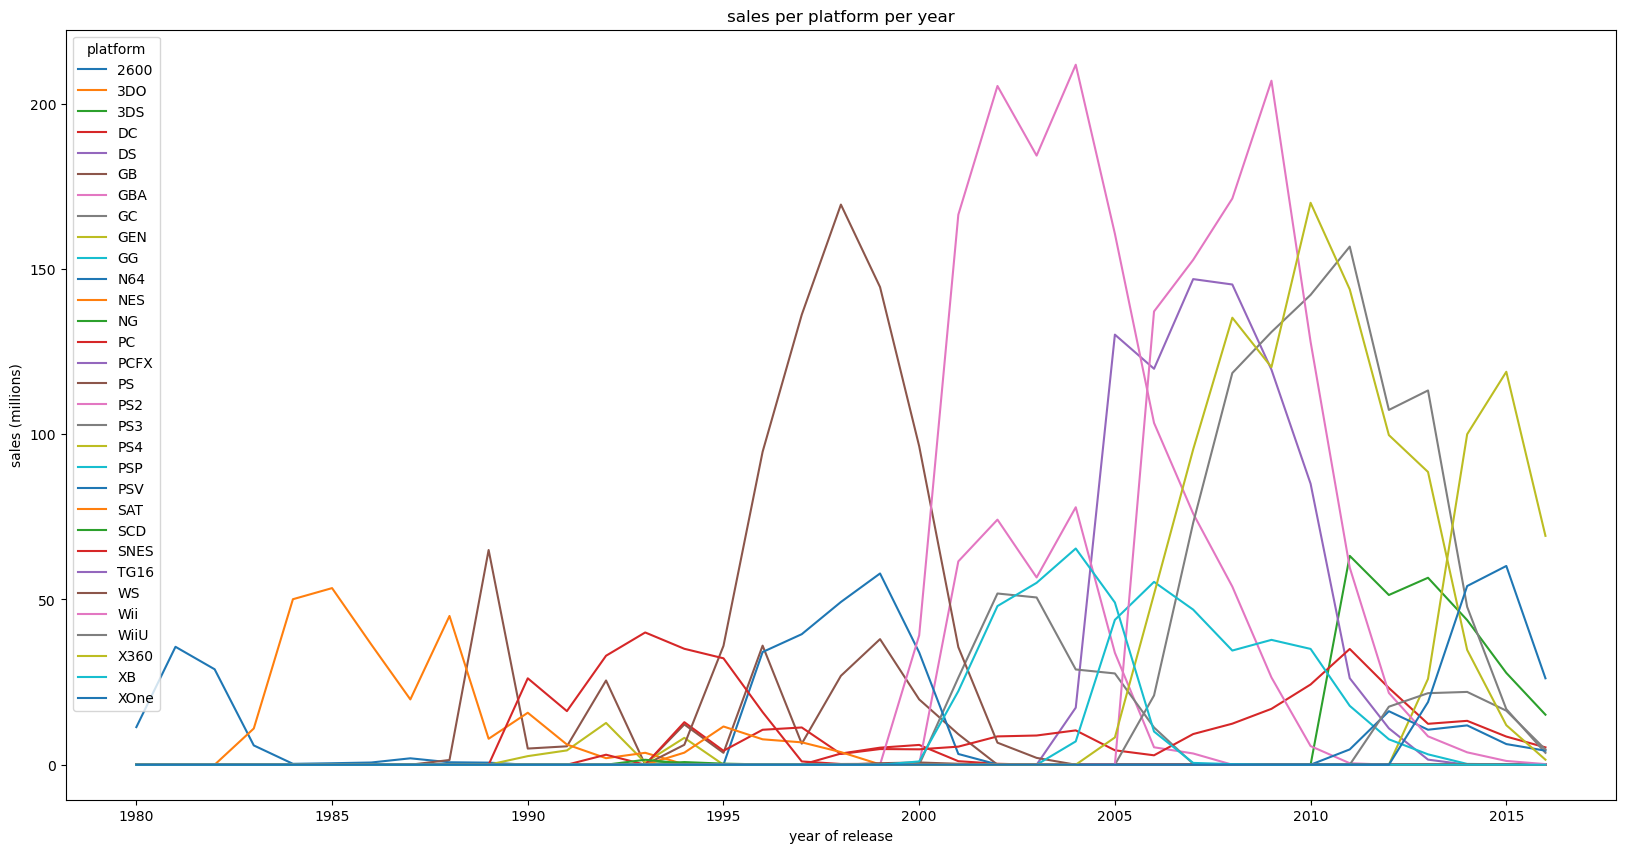

In [10]:
# agrupacion por plataforma y ventas 
#We group by platfrom and sales 


platforms_sales_per_year = videogames.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
# pivoteamos la tabla para tener los valores unicos agrupados en columnas para poder graficar
#We pivot the table to be able to see it. 
platforms_sales_per_yearPiv = platforms_sales_per_year.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)


platforms_sales_per_yearPiv.plot(kind = 'line',                             
                            
                              title = 'sales per platform per year',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (20,10),
                             )
plt.show()




#Esp: como podemos ver en la tabla los valores tienen una dispersion muy grande por anio asi que lo mejor es reagrupar en periodos de tiempo mas manejables para su visualizacion, en este caso vamos a divir en los siguientes periodos. 
primer periodo = 1980-1989
segundo periodo = 1990-1999
tercer periodo =  2000-2009
cuarto periodo =  2010-2016

#ENG As we can see the values on the table have a lot of dispertion per year so we are going to group it in more managable timeframes. 
First period = 1980-1989
Second period = 1990-1999
Third  period =  2000-2009
Fourth period =  2010-2016


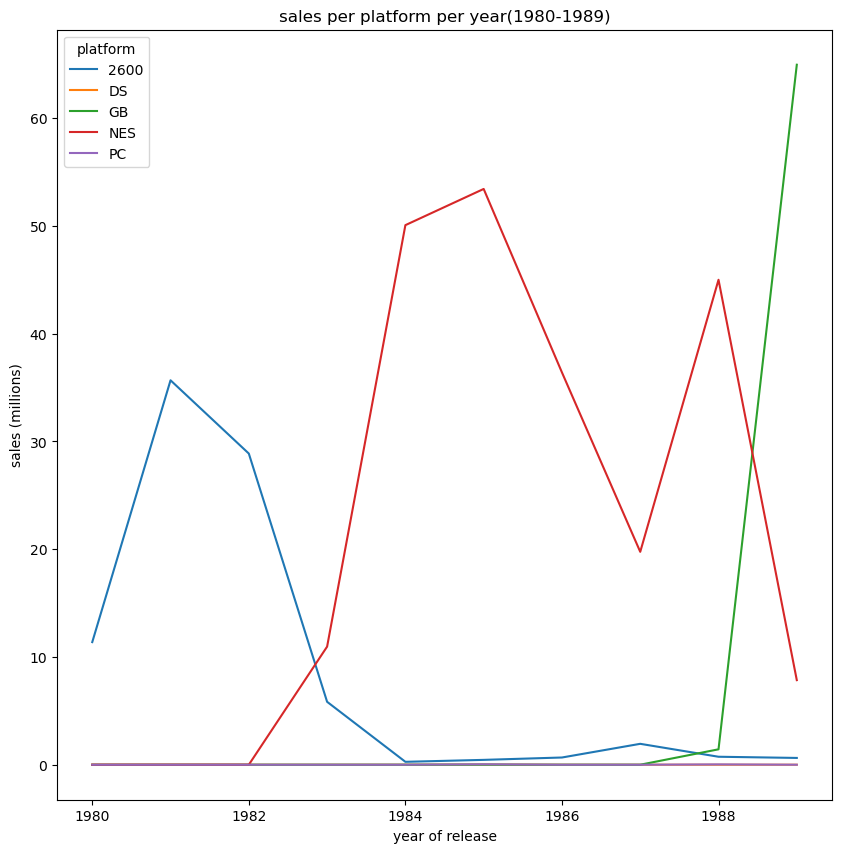

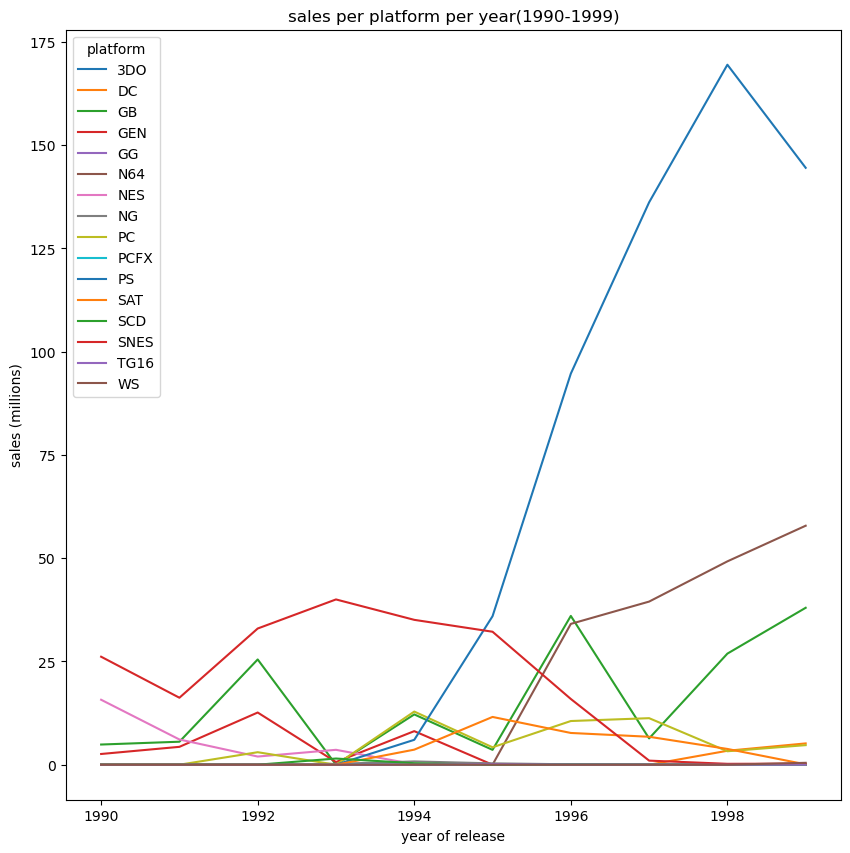

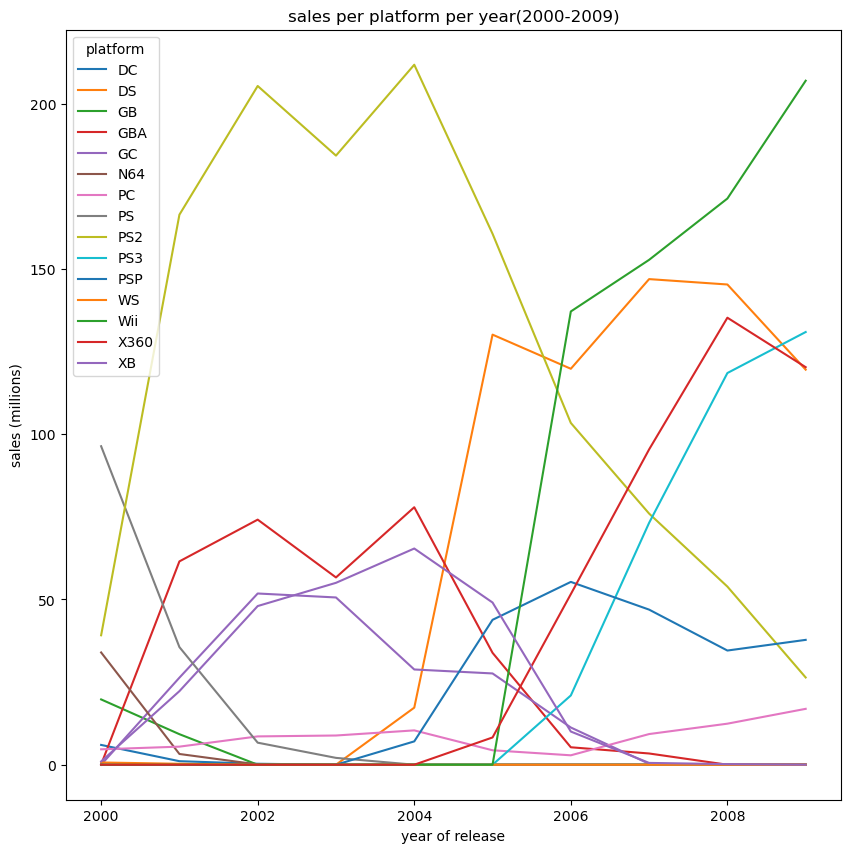

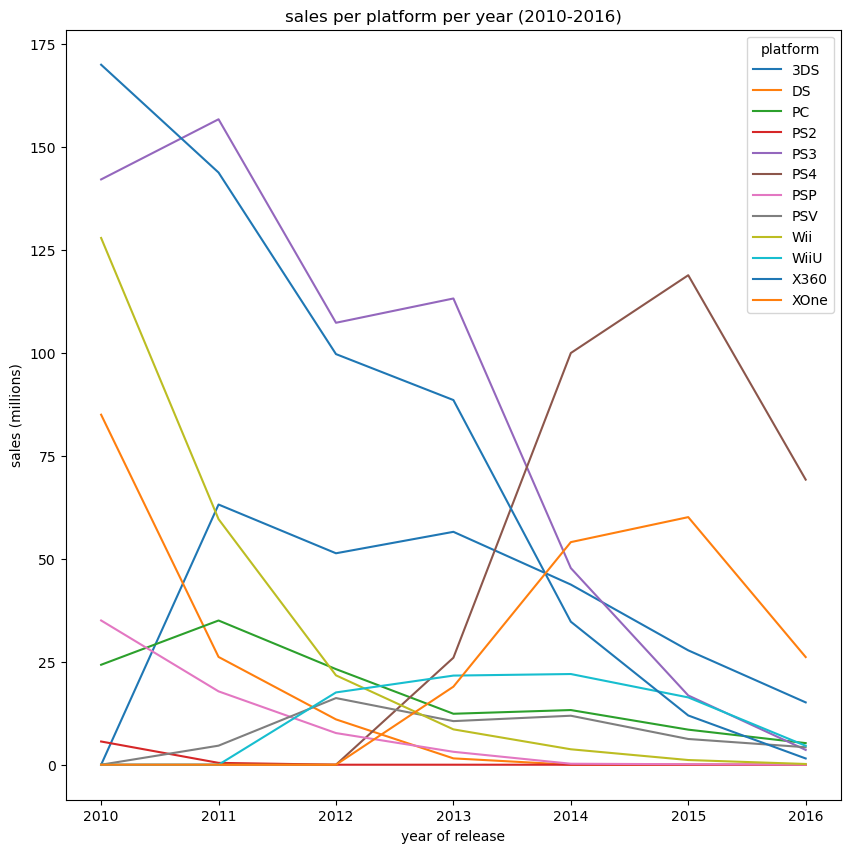

In [11]:
platforms_sales_per_year = videogames.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()



platforms_sales_1980_1989 = platforms_sales_per_year[(platforms_sales_per_year['year_of_release'] >= 1980) & (platforms_sales_per_year['year_of_release'] < 1990)]
platforms_sales_1990_1999 = platforms_sales_per_year[(platforms_sales_per_year['year_of_release'] >= 1990) & (platforms_sales_per_year['year_of_release'] < 2000)]
platforms_sales_2000_2009 = platforms_sales_per_year[(platforms_sales_per_year['year_of_release'] >= 2000) & (platforms_sales_per_year['year_of_release'] < 2010)]
platforms_sales_2010_2016 = platforms_sales_per_year[(platforms_sales_per_year['year_of_release'] >= 2010) & (platforms_sales_per_year['year_of_release'] < 2017)]

platforms_sales_1980_1989PIV = platforms_sales_1980_1989.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)
platforms_sales_1990_1999PIV = platforms_sales_1990_1999.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)
platforms_sales_2000_2009PIV = platforms_sales_2000_2009.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)
platforms_sales_2010_2016PIV = platforms_sales_2010_2016.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)


platforms_sales_1980_1989PIV.plot(kind = 'line',                             
                            
                              title = 'sales per platform per year(1980-1989)',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (10,10),
                             )
plt.show()


platforms_sales_1990_1999PIV.plot(kind = 'line',                             
                            
                              title = 'sales per platform per year(1990-1999)',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (10,10),
                             )
plt.show()

platforms_sales_2000_2009PIV.plot(kind = 'line',                             
                            
                              title = 'sales per platform per year(2000-2009)',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (10,10),
                             )
plt.show()

platforms_sales_2010_2016PIV.plot(kind = 'line',                             
                            
                              title = 'sales per platform per year (2010-2016)',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (10,10),
                             )
plt.show()


# esp: Al momento en este analisis podemos ver que ha habido un incremento en las ventas de consolas y como se van dando periodos cuando surge una consola nueva y esta sube en ventas mientras las otras bajan. Esto es debido a las generaciones de consolas 
#ENG: At this point we can see that there is a period where consoles spike and how they decline when a new one comes out. The origin of this is the generations of consoles. 

#ESP:Vamos a utilizar solamente los datos de 2012 en adelante que corresponden a la octava generacion de consolas. 
Consideraciones especiales. 
Dado que queremos perfiles que sirvan para 2017 en adelante si hay datos que tienen 0.0 como en algunas consolas, o que van a la baja se van a eliminar para tener datos relevantes para el estudio. Mediante esto vamos a droppear las siguientes consolas 
3DS, DS, PS3, PSP, PSPV, Wii, X360
#ENG: We are going to use data from 2012 to 2016 since this correspond to the eight generation of consoles.
Special considerations: 
We want profiles to be useful for 2017 and up so if there is any data with a 0.0 like some consoles, or consoles that are being phased out we are going to eliminate them to only have relevant data for the study. We are going to drop the following consoles. 
3DS, DS, PS3, PSP, PSPV, Wii, X360


In [12]:
#Generamos otro data frame con solo los valores de esos anios y consolas relevantes 
#We generate another data frame with only the relevant years and without the dwindling consoles. 

eliminatedPlatforms = ['3DS','DS', 'PS3', 'PSP','PSV', 'Wii', 'X360']
gen8vg = videogames[(videogames['year_of_release']> 2011) & (~videogames['platform'].isin(eliminatedPlatforms))] 
display (gen8vg )



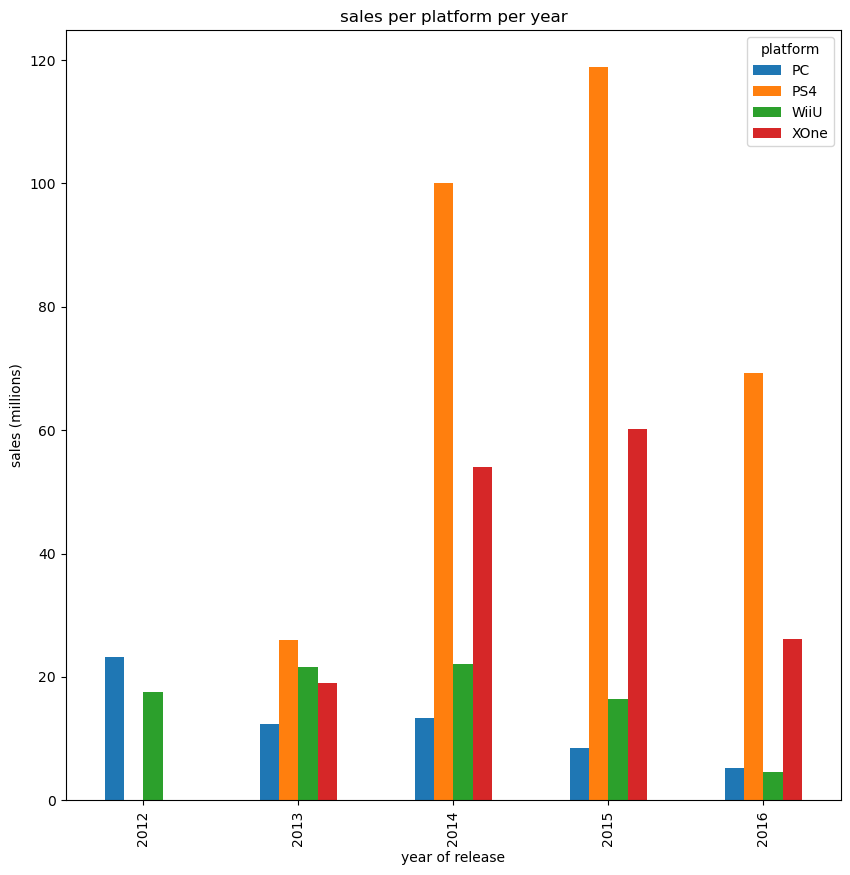

In [13]:
#Vamos a checar las ventas de las plataformas 
#Lets check the sales per platform per year
gen8SalesPerPlatform = gen8vg.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index() 

gen8SalesPerPlatformPIV =  gen8SalesPerPlatform.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)

gen8SalesPerPlatformPIV.plot(kind = 'bar',                             
                            
                              title = 'sales per platform per year',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (10,10),
                             )
plt.show()




#ESP: Vemos que las venta de consolas d esu lanzamiento en 2013 suben las de play4 y xbox one y bajan en 2016, esto puede deberse a falta de datos por el comportamiento observado ya que todos tienen menos datos disponibles. Las ventas de PC se mantienen estables. 
#ENG We see that the console sales from their launch on 2013 to 2016 increase every year before dropping on 2016. The drop could be because of lack of data as it does not follow the behaviour presented. 

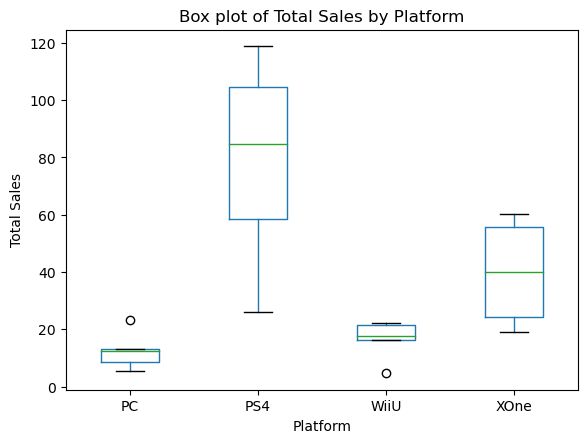

In [14]:
#Vamos a ver las ventas totales por plataforma
#LEts see the total sales per platform. 

boxplot = gen8SalesPerPlatform.boxplot(column='total_sales', by='platform', grid=False)
plt.title('Box plot of Total Sales by Platform')
plt.suptitle('')  # Remove default title
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.show()



In [15]:
# Lets check the total sales per platform of the games. 
#vamos a ver las ventas por plataforma 
gen8GamesGroup = gen8vg.groupby(['platform', 'name'])['total_sales'].sum().reset_index() 

display (gen8GamesGroup.sample(10) )

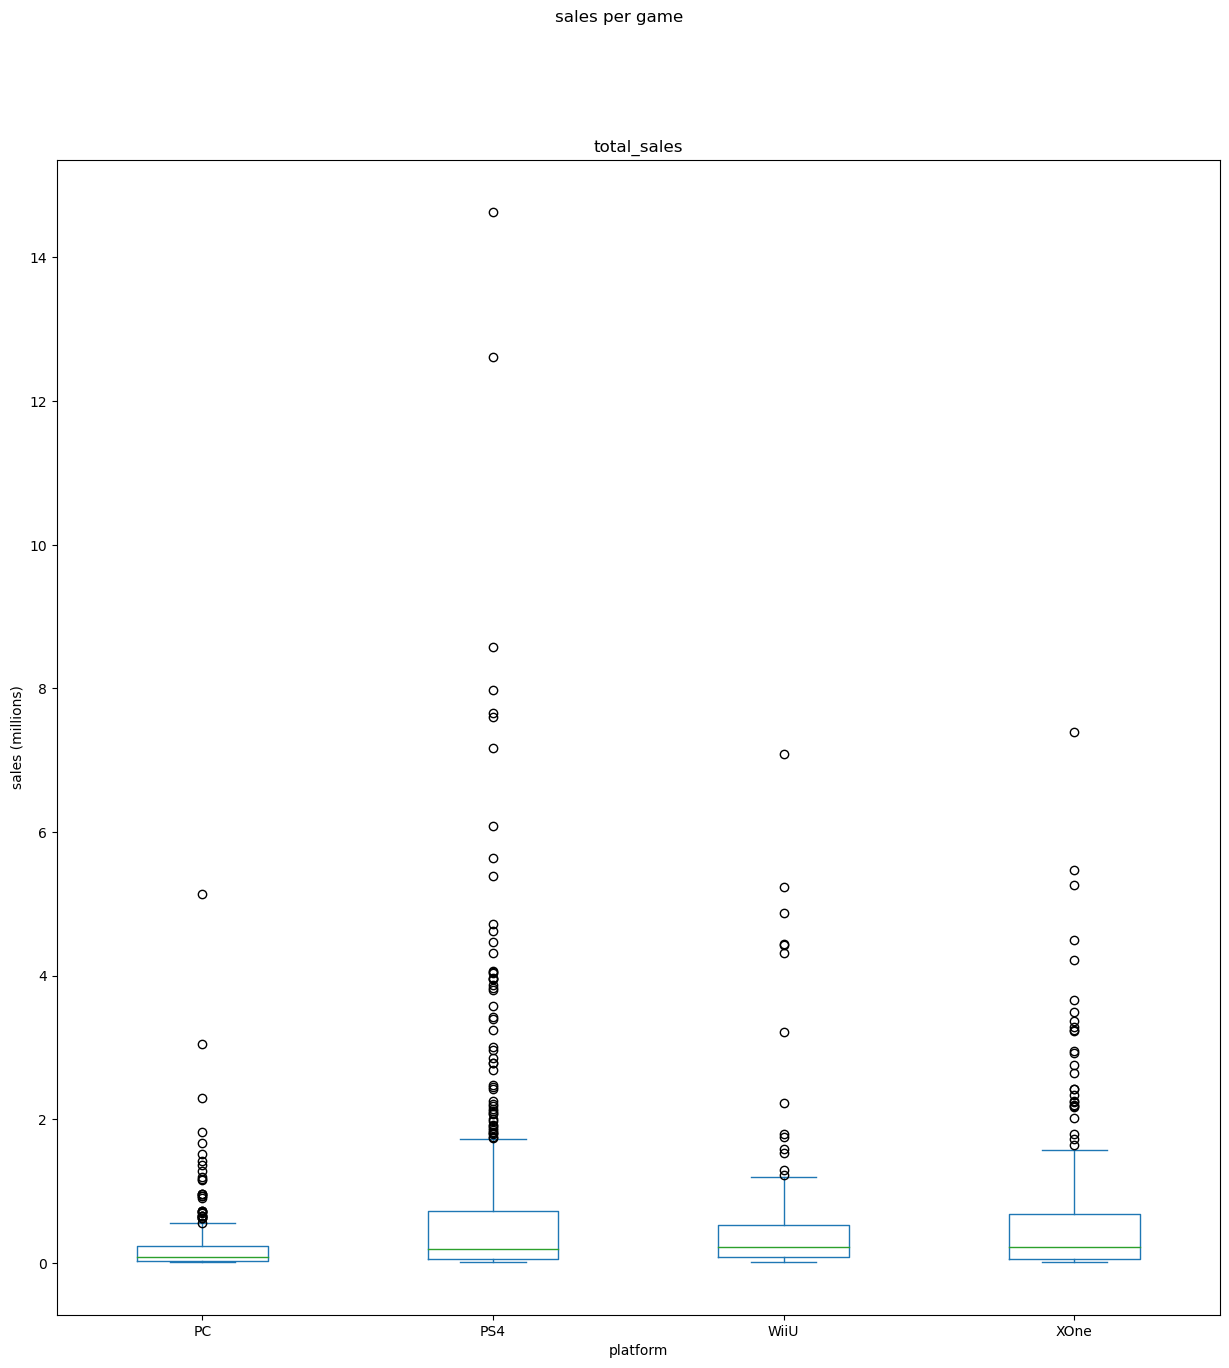

In [16]:
#for platform in  gen8GamesGroup: 
DataToPlot = gen8GamesGroup
DataToPlot.plot(kind = 'box',  
                    by = 'platform',
                    title = 'sales per game',
                    xlabel = 'platform',
                    ylabel= 'sales (millions)',
                    figsize= (15,15)
                             )
plt.show()

    




ESP: Vemos que la mayoria de los juegos se quedan en menos de 1 millon de dolares pero hay muchos outliers que tienen ventas superiores a la media. 
ENG: We see that most games sell below 1 million dollars but there are outliers with sales that are superior to the mean. 

ESP: vamos a Analizar las ventas si las resenias de usuarios afectan. Para esto vamos a elegir la plataforma PS4 y comparar las ventas contra las resenias. En este caso primero vamos a excluir los juegos que no cuentan con resenias  
ENG: We are going to analyse if the reviews are related to the sales of a game on one platform in this case PS4 

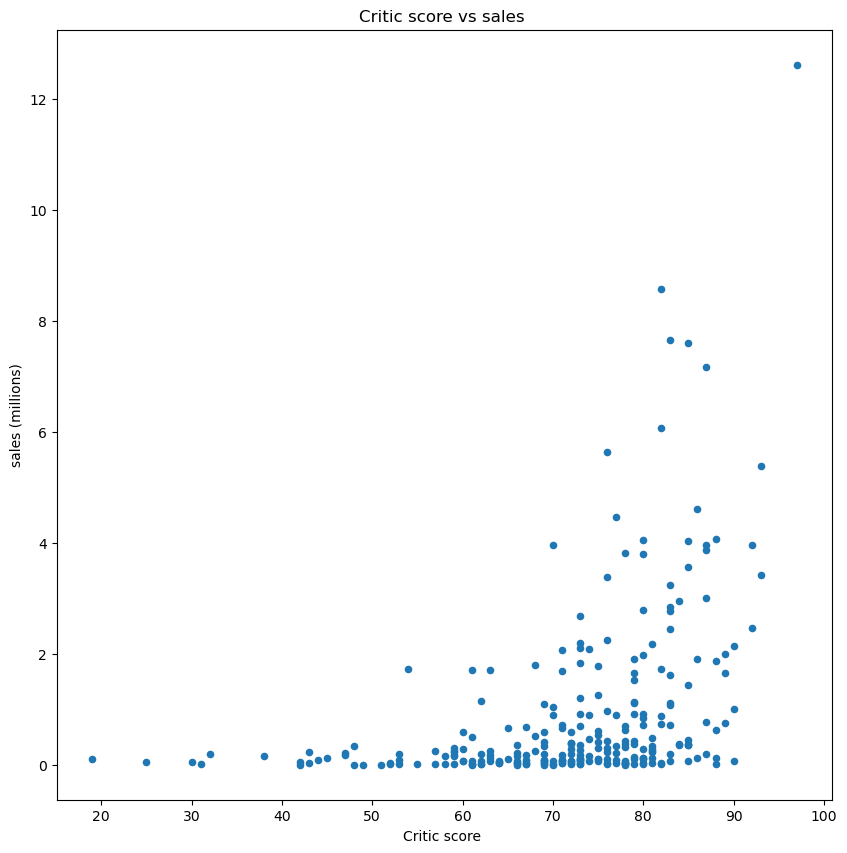

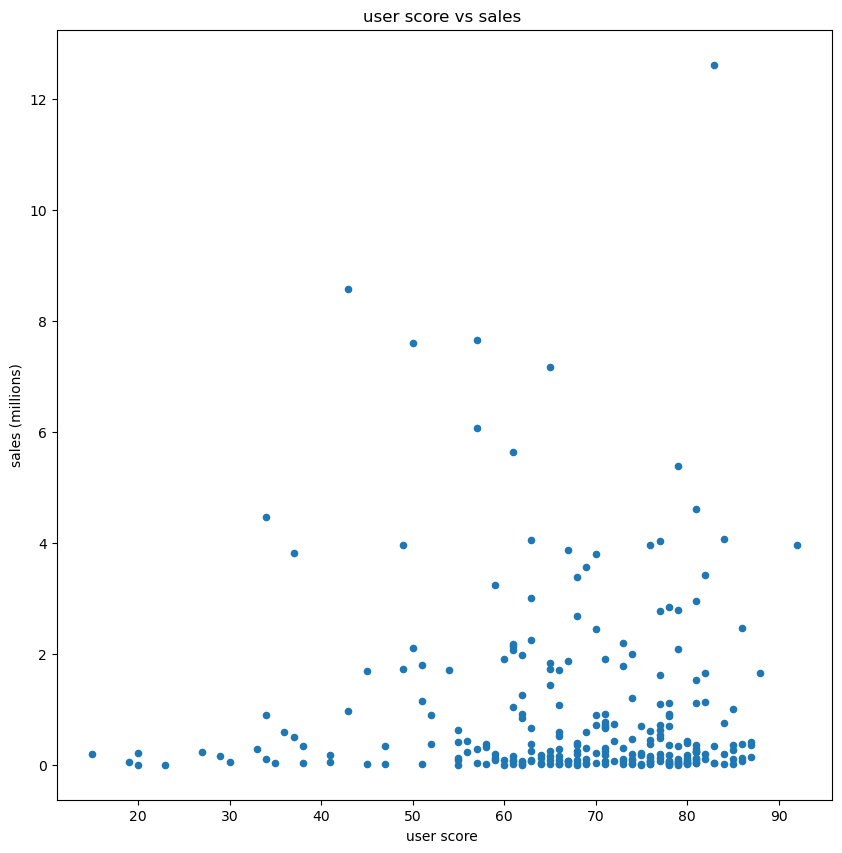

In [17]:
#preparacion de los datos checamos que sean de PS4 y despues que tengan datos validos en ambas columnas. 
#We check the data on only PS4 and that it has relevant information on the columns we seek. 

ps4GamesAndReviews = gen8vg[(gen8vg['platform']=='PS4') &  (gen8vg['critic_score'].notna()) & (gen8vg['critic_score'].notna())]

ps4GamesAndReviews.plot.scatter(x = 'critic_score',
                                y='total_sales',
                    title = 'Critic score vs sales ',
                    xlabel = 'Critic score ',
                    ylabel= 'sales (millions)',
                    figsize= (10,10)
                             )
ps4GamesAndReviews.plot.scatter(x = 'user_score',
                                y='total_sales',
                    title = 'user score vs sales ',
                    xlabel = 'user score ',
                    ylabel= 'sales (millions)',
                    figsize= (10,10)
                             )

plt.show()

In [18]:
#Checamos con corr la correlacion vista en las graficas 
#We check with Corr the correlation seen in the graphs 
correlation_Critic = ps4GamesAndReviews[['critic_score', 'total_sales']].corr()
correlation_user = ps4GamesAndReviews[['user_score', 'total_sales']].corr()

display (correlation_Critic )
display (correlation_user )

##Analis de los score
Vemos que los scores estan debilmente correlacionados en cuanto a la critica y ventas al tener un valor de 0.4
Los reviews de los usuarios no estan correlacionados a las ventas al tener un valor cercano a 0 

##Score analysis 
We see that the critic scores are weakly postively related to the total sales with a value of 0.4 
We also see that the user score is not correlated  as it has a near 0 value.



#ESP Mismos juegos en diferentes plataformas 
Vamos a checar como se comportan las ventas de los mismos juegos en varias plataformas. Para este analisis solo vamos a usar juegos que tengan critic y user score validos. Asi mismo vamos a limitar el espacio a un solo anio en este caso 2016  en adelante. 

#ENG: Same game different platforms. We are going to observe how are the sales of the same game on different platforms. For this analysis we are going to only use those that have a valid user and critic score. We are also limiting to 2016 

In [45]:
#Checamos juegos en multiplat
# we check for repeated games. 
MultiplatformGame = gen8vg[gen8vg.duplicated('name', keep=False)]
MultiplatformGame= MultiplatformGame[MultiplatformGame['year_of_release'] ==2016]
MultiplatformGame = MultiplatformGame.dropna()


MultiplatformGame = MultiplatformGame.groupby(['platform', 'name'])['total_sales'].sum().reset_index() 

# Display the result
display(MultiplatformGame.sort_values(by='name'))

In [49]:
#vamos a extraer en otro dataframe los que tengan menos de 1 millon en ventas para tener solo aquellos que vendieron mas de medio millon en total
# we only use the data from games that sold more than 0.5 million in USD. 

MultiplatformGameSales = MultiplatformGame.groupby(['name'], as_index =False)['total_sales'].sum()
MultiplatformGameSales= MultiplatformGameSales[MultiplatformGameSales['total_sales'] > 0.49]
MultiplatformGameSales = MultiplatformGameSales.sort_values(by='total_sales', ascending =False)
MultiplatformGameSales.set_index('name',inplace=True)
display(MultiplatformGameSales)


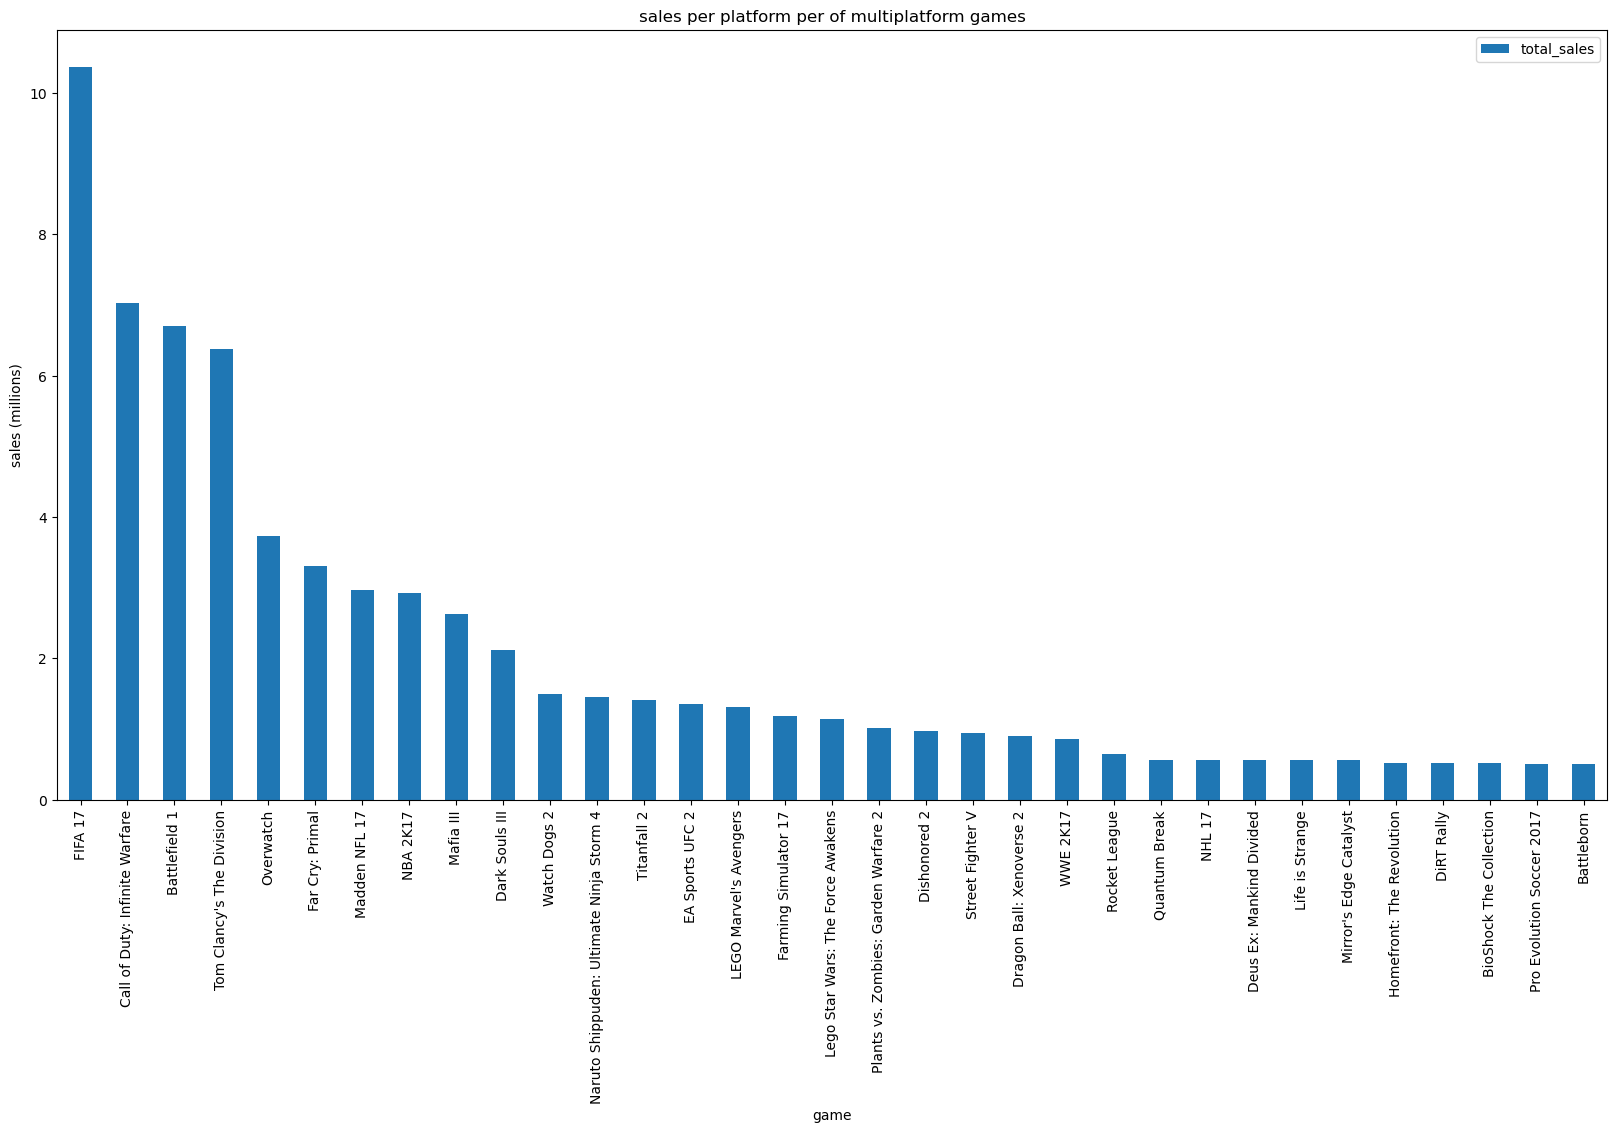

In [50]:
#We group it to display it 
#lo agrupamos para verlo 
#MultiplatformGameSales = MultiplatformGameSales.groupby(['name'])['total_sales'].sum().unstack()

MultiplatformGameSales.plot(kind = 'bar',                             
                            
                              title = 'sales per platform per of multiplatform games',
                              xlabel = 'game',
                              ylabel= 'sales (millions)',
                              figsize= (20,10),
                             )
plt.show()



#ESP: Vemos que los juegos mas populares en multiplataforma son los shooters y lineas populares como fifa,battlefield o Call of duty.
#ENG: We see how the most popular multiplatform games are shooters and popular lines such as Fifa, Battlefield or Call of Duty 


#ESP: Analizar ventas por genero 
#ENG: Sales analysis by genre. 

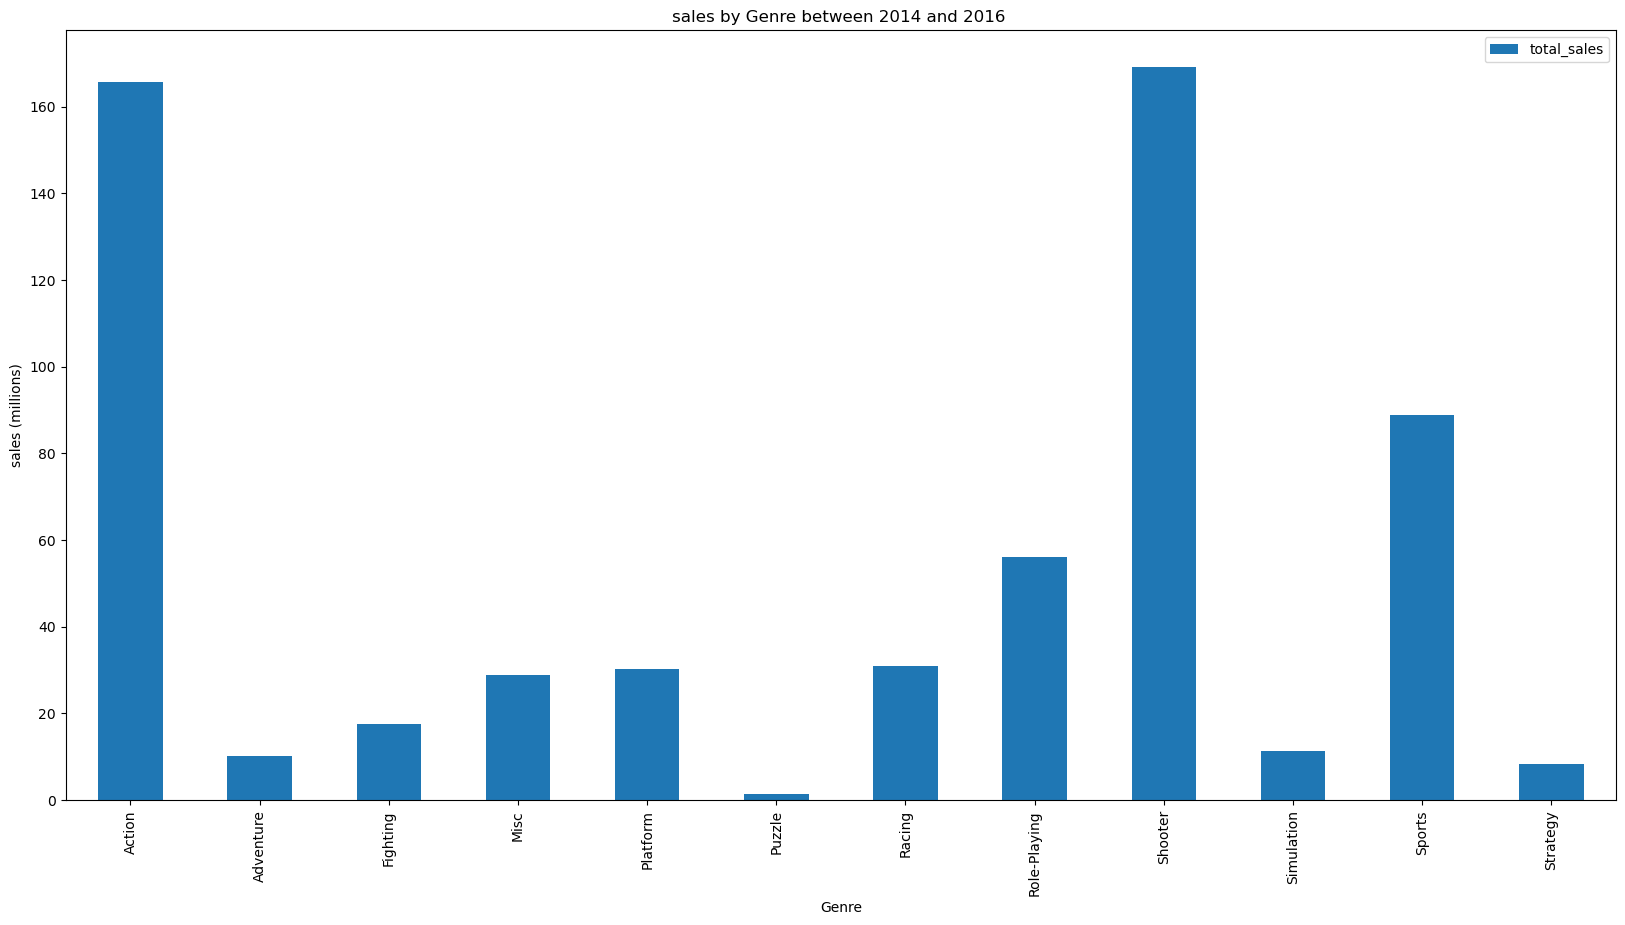

In [25]:
#primero vamos a agrupar basandonos en genero y ver las ventas 
#group based on genre 

SalesByGenre = gen8vg.groupby(['genre'])['total_sales'].sum().reset_index() 
SalesByGenre.plot(kind = 'bar',
                  x= 'genre',
                            
                              title = 'sales by Genre between 2014 and 2016 ',
                              xlabel = 'Genre',
                              ylabel= 'sales (millions)',
                              figsize= (20,10),
                             )
plt.show()




#ESP Conclsuiones genero 
Los juegos de accion, shooter y deportes son los mas populares.
ENG: 
Action, shooter and Sports games are the msot popular ones. 

# # Crear perfiles de usuario 
## create user profiles 

#ESP
En esta seccion vamos a crear perfiles de usuario para cada region NA, UE, y JP.
En cada region vamos a describir las 5 plataformas principales, asi como su market share. 
Los cinco generos principales de cada region. 
si las clasificaciones de la ESRB afectan las ventas en regiones 
Con esto se va a crear el perfil de usuario de cada region. 
Al final de esta seccion habra un data frame por region ( NA, UE, JP) que contendra la siguiente informacion
1. las 5 principales consolas y sus numeros en ventas
2. los 5 generos mas populares por region y sus ventas. 

#ENG
In this section we are going to create user profiles for each region, Nortamerica (NA). Japan(JP, and European union (UE) 
We are going to see the five most popular platforms and their market share. the most popular genres and if the ESRB affects sales. 
At the end we are going to get a data frame that has the following information
1. 5 most popular consoles and their sales
2. 5 most popular genres. 



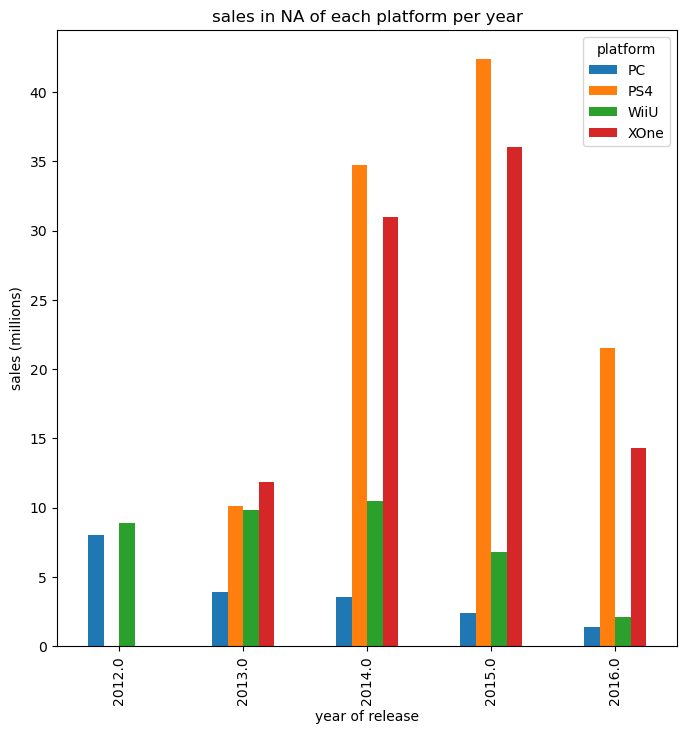

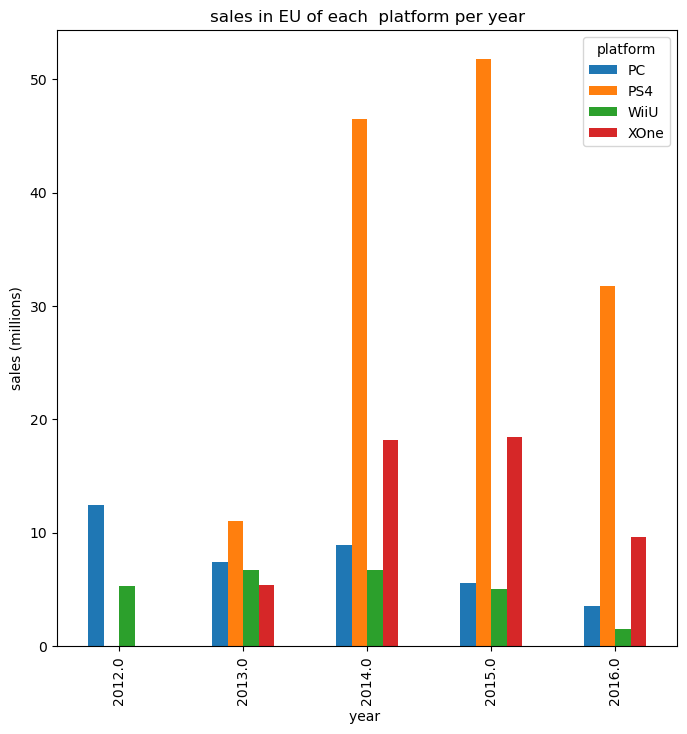

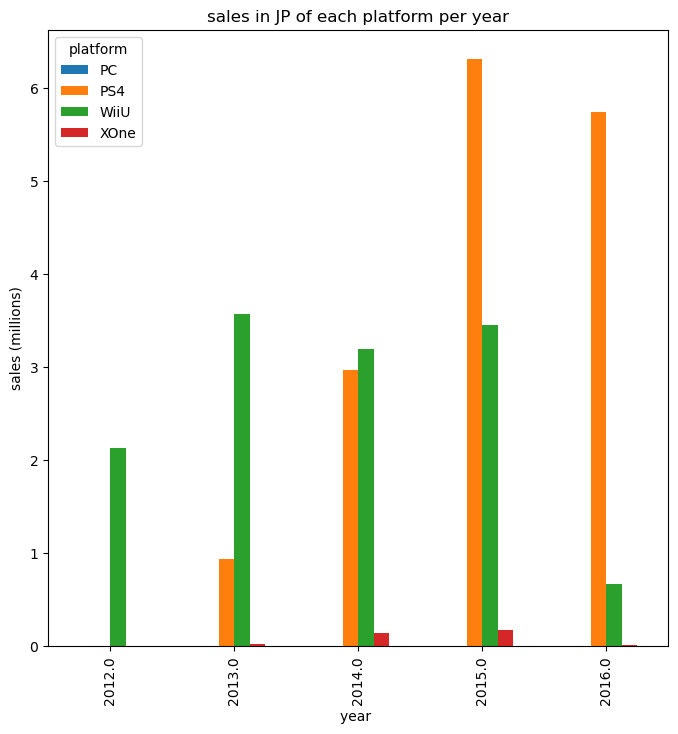

In [30]:
#el primer paso es separar por region.
#separete by region 

NARegionSales  = gen8vg.groupby(['platform','year_of_release'])['na_sales'].sum().reset_index().sort_values(by='na_sales', ascending=False)   
EURegionSales  = gen8vg.groupby(['platform','year_of_release'])['eu_sales'].sum().reset_index().sort_values(by='eu_sales', ascending=False)   
JPRegionSales  = gen8vg.groupby(['platform','year_of_release'])['jp_sales'].sum().reset_index().sort_values(by='jp_sales', ascending=False)   


#pivotear para graficar
#pivot to plot 
NARegionSalePIV =  NARegionSales.pivot_table(index='year_of_release', columns='platform', values='na_sales', aggfunc='sum', fill_value=0)
EURegionSalesPIV =  EURegionSales.pivot_table(index='year_of_release', columns='platform', values='eu_sales', aggfunc='sum', fill_value=0)
JPRegionSalesPIV =  JPRegionSales.pivot_table(index='year_of_release', columns='platform', values='jp_sales', aggfunc='sum', fill_value=0)

NARegionSalePIV.plot(kind = 'bar',                             
                            
                              title = 'sales in NA of each platform per year',
                              xlabel = 'year of release',
                              ylabel= 'sales (millions)',
                              figsize= (8,8),
                             )
plt.show()

EURegionSalesPIV.plot(kind = 'bar',                             
                            
                              title = 'sales in EU of each  platform per year',
                              xlabel = 'year ',
                              ylabel= 'sales (millions)',
                              figsize= (8,8),
                             )
plt.show()



JPRegionSalesPIV.plot(kind = 'bar',                             
                            
                              title = 'sales in JP of each platform per year',
                              xlabel = 'year ',
                              ylabel= 'sales (millions)',
                              figsize= (8,8),
                             )
plt.show()






#ESP: Vemos que en EU y NA PS4 y Xbox one son las mas populares mientras que en JP es PS4 y Wiiu 
#Eng: In EU and NA PS4 and Xbox one are the most popular while in JP is PS4 and Wiiu 

In [31]:
# cinco generos principales 
#five most important Genres 

NAGenreSales  = gen8vg.groupby(['genre'])['na_sales'].sum().reset_index().sort_values(by='na_sales', ascending=False) 
EUGenreSales  = gen8vg.groupby(['genre'])['eu_sales'].sum().reset_index().sort_values(by='eu_sales', ascending=False) 
JPGenreSales  = gen8vg.groupby(['genre'])['jp_sales'].sum().reset_index().sort_values(by='jp_sales', ascending=False)  

display (NAGenreSales.head(5))
display (EUGenreSales.head(5))
display (JPGenreSales.head(5))

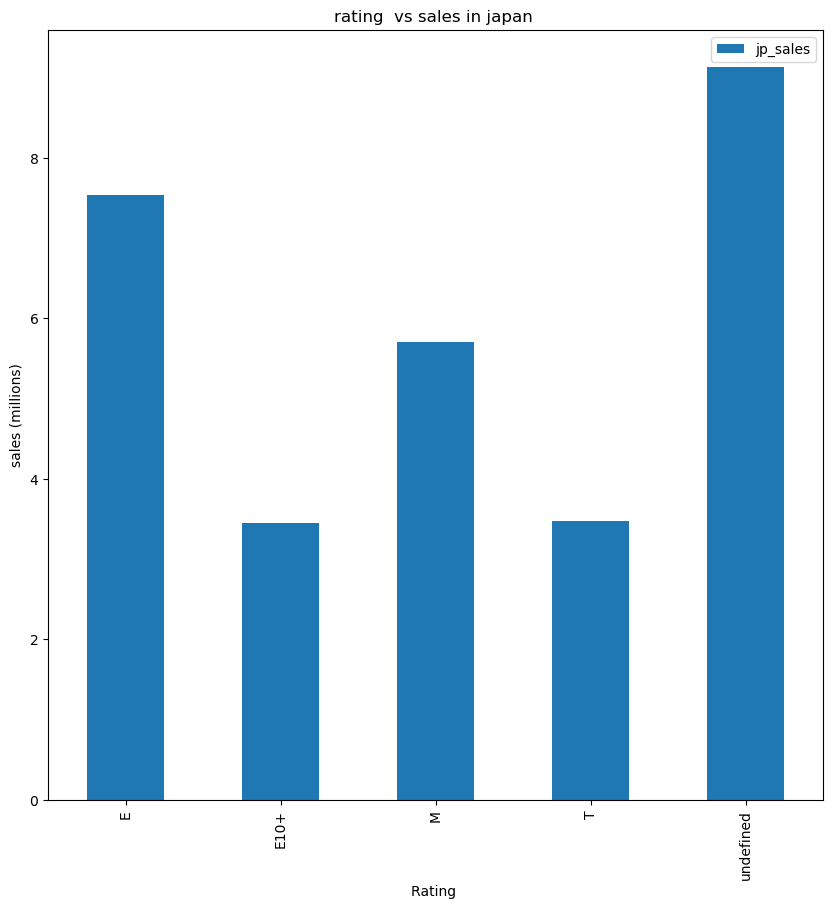

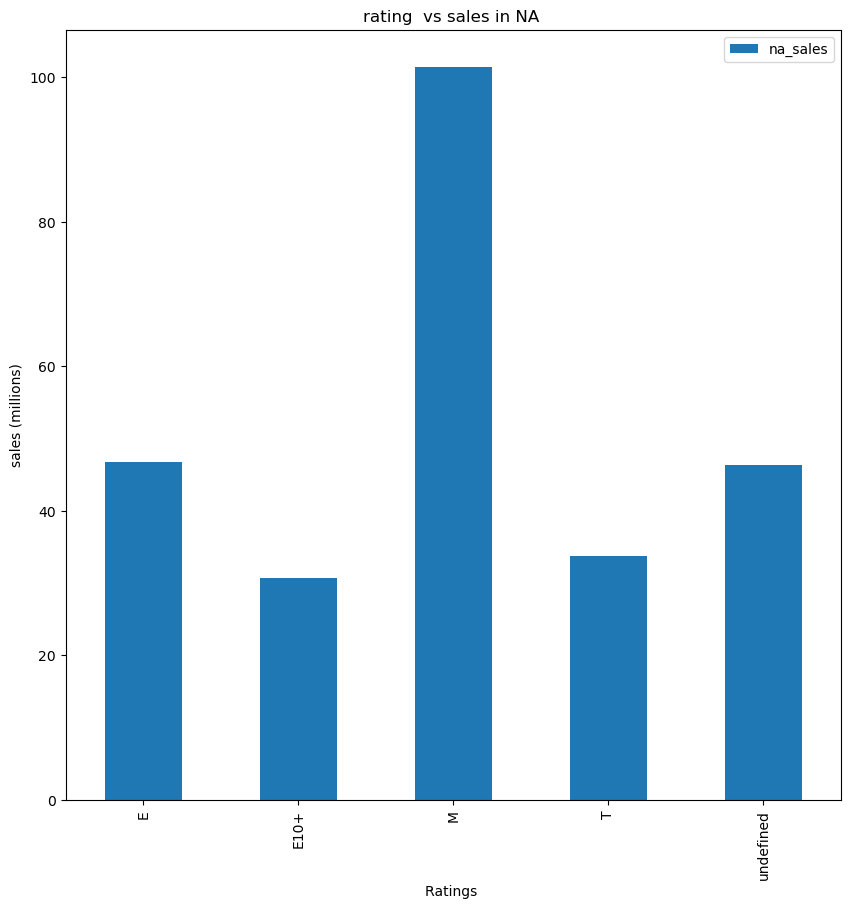

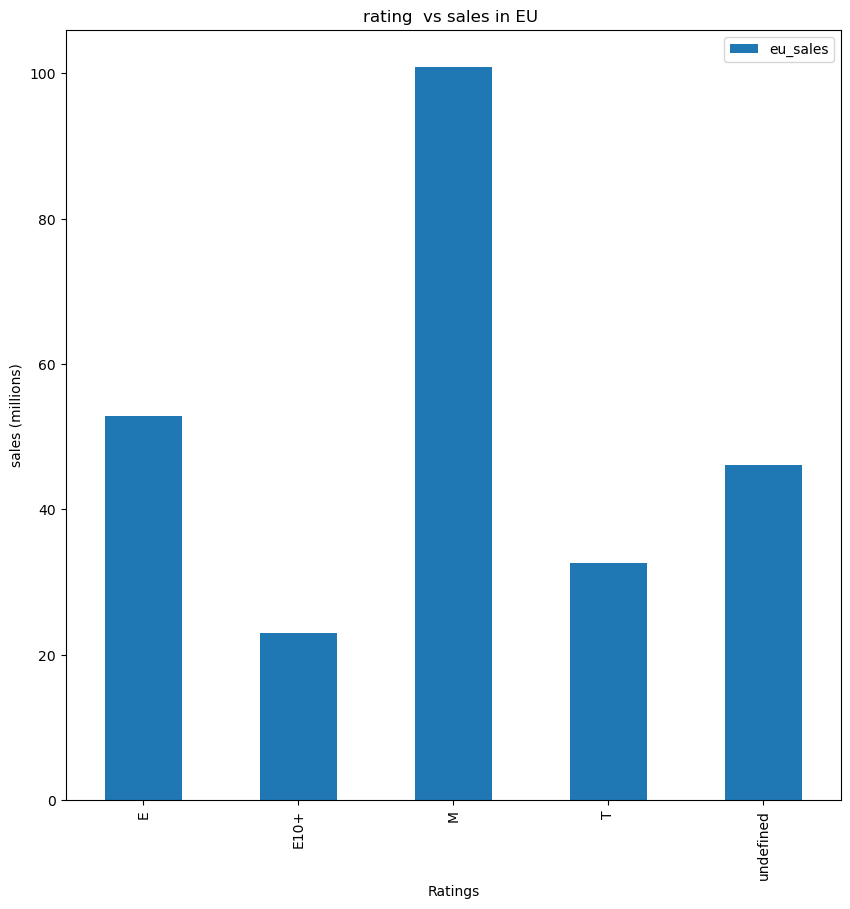

In [32]:
#comparativa de la ESRB 
#ESRB comparision

ESRBJP = gen8vg.groupby(['rating'])['jp_sales'].sum().reset_index()
ESRBJP.plot(kind='bar',
                x = 'rating',
                y='jp_sales',
                    title = 'rating  vs sales in japan ',
                    xlabel = 'Rating ',
                    ylabel= 'sales (millions)',
                    figsize= (10,10)
                             )

plt.show()

ESRBNA = gen8vg.groupby(['rating'])['na_sales'].sum().reset_index()
ESRBNA.plot(kind='bar',
                x = 'rating',
                y='na_sales',
                    title = 'rating  vs sales in NA ',
                    xlabel = 'Ratings ',
                    ylabel= 'sales (millions)',
                    figsize= (10,10)
                             )

plt.show()


ESRBEU = gen8vg.groupby(['rating'])['eu_sales'].sum().reset_index()
ESRBEU.plot(kind='bar',
                x = 'rating',
                y='eu_sales',
                    title = 'rating  vs sales in EU ',
                    xlabel = 'Ratings',
                    ylabel= 'sales (millions)',
                    figsize= (10,10)
                             )

plt.show()


##  Perfiles de cada region 


In [33]:
#NortamericanMarketProfile
#Primero sacamos el perfil de ventas por consolas 
NAProfileSales = gen8vg.groupby(['platform'])['na_sales'].sum().reset_index().sort_values(by='na_sales', ascending=False)
TotalPlatforMarketShare = NAProfileSales['na_sales'].sum()
#despues el de generos mas comunes 
TotalESRBNASales = ESRBNA['na_sales'].sum()
NAProfileSales['percentage'] = (NAProfileSales['na_sales'] / TotalPlatforMarketShare* 100)
ESRBNA['percentage'] =(ESRBNA['na_sales'] / TotalESRBNASales* 100)
#finalmente el de generos 
NAGenreSales['percentage'] = (NAGenreSales['na_sales'] / TotalPlatforMarketShare* 100)

display (NAProfileSales )
display ( ESRBNA.sort_values(by='na_sales', ascending=False))
display ( NAGenreSales.sort_values(by='na_sales', ascending=False).head(5))

Norteamerica tiene el siguiente perfil 

1.El mercado es ventas es de  de Consolas mas popular es el PS4 seguida del XOne que entre ambas juntan el 78% del mercado 
2. En cuanto a generos los mas populares son shooter, accion y deportes. 
3. Las clasificaciones de la ESRB indican que los juegos mas vendidos son M ( mayores de 18) y E ( todo publico 

#ENG 
Northamerica has the following profile 
1. PS4 and Xbox one have the biggest market share with over 78% of the market
2. Shooter, action and sports are the most popular genres
3. ESRB indicate that the most sold games are M ( 18+ games) and E ( all audiences) 

In [46]:
#EUMarketProfile
#Primero sacamos el perfil de ventas por consolas 
EUProfileSales = gen8vg.groupby(['platform'])['eu_sales'].sum().reset_index().sort_values(by='eu_sales', ascending=False)
TotalPlatforMarketShare = EUProfileSales['eu_sales'].sum()
#despues el de generos mas comunes 
TotalESRBSales = ESRBEU['eu_sales'].sum()
EUProfileSales['percentage'] = (EUProfileSales['eu_sales'] / TotalPlatforMarketShare* 100)
ESRBEU['percentage'] =(ESRBEU['eu_sales'] / TotalESRBSales* 100)
#finalmente el de generos 
EUGenreSales['percentage'] = (EUGenreSales['eu_sales'] / TotalPlatforMarketShare* 100)

display (EUProfileSales )
display ( EUGenreSales.sort_values(by='eu_sales', ascending=False))
display ( ESRBEU.sort_values(by='eu_sales', ascending=False).head(5))

Europa tiene el siguiente perfil 

1.El mercado es ventas es de  de Consolas mas popular es el PS4 seguida del XOne que entre ambas juntan el 75% del mercado 
2. En cuanto a generos los mas populares son Accion, Shooter y deportes. 
3. Las clasificaciones de la ESRB indican que los juegos mas vendidos son M ( mayores de 18) y E ( todo publico)

El perfil es muy similar al de norteamerica. 

#ENG 
Europe  has the following profile 
1. PS4 and Xbox one have the biggest market share with over 75% of the market
2. Shooter, action and sports are the most popular genres
3. ESRB indicate that the most sold games are M ( 18+ games) and E ( all audiences) 
The profile is similar to the one in NA 

In [48]:
#JPMarketProfile
#Primero sacamos el perfil de ventas por consolas 
JPProfileSales = gen8vg.groupby(['platform'])['jp_sales'].sum().reset_index().sort_values(by='jp_sales', ascending=False)
TotalPlatforMarketShare = JPProfileSales['jp_sales'].sum()
JPProfileSales['percentage'] = (JPProfileSales['jp_sales'] / TotalPlatforMarketShare* 100)

#despues el de ESRB  
TotalESRBSales = ESRBJP['jp_sales'].sum()
ESRBJP['percentage'] =(ESRBJP['jp_sales'] / TotalESRBSales* 100)

#finalmente el de generos 
JPGenreSales['percentage'] = (JPGenreSales['jp_sales'] / TotalPlatforMarketShare* 100)

display (JPProfileSales )
display ( JPGenreSales.sort_values(by='jp_sales', ascending=False))
display ( ESRBJP.sort_values(by='jp_sales', ascending=False).head(5))

#ESP 
Japon  tiene el siguiente perfil 
1.El mercado es ventas es de  de Consolas mas popular es el PS4 seguida del WiiU teniendo solo una diferencia del 10%. En esta region el Xone que esta presente en las otras apenas cumple el 1,16% 
2. En cuanto a generos los mas populares son Accion, Shooter y Roleplaying teniendo estos dos ultimos casi el mismo valor que plataformas. 
3. Las clasificaciones de la ESRB indican que los juegos mas vendidos son sindefinir seguido de E ( todo publico). En este caso el undefined puede deberse a que juegos desarrollados en japon que no son exportados a Norteamerica no reciben clasificacion de la ESRB 
#ENG 
Japan has the following profile 
1. The console market the most popular one is the PS4 followed by the Wiiu with only a market share differenced of 10%. IN this region the Xbox one barely makes the 1,16%.
2. Action, shooter and roleplaying games are the most popular with roleplaying games being almost the same as platforms.
3. The ESRB shows that the most sold games are Undefined followed by E. IN this case the amount of undefined could be because japan developed games that are not exported to western markets do not receive an ESRB clasification. 



## Prueba de hipotesis 
## Hypotehsis test 
#ESP 
Vamos a probar las siguientes hipotesis. 
1. Las calificaciones promedio de los usuarios para las plataformas de Xbox one y PC son las mismas. 
2. Las calificaciones promedio de los usuarios para los generos de accion y deportes son diferentes. 

#ENG 
We are going to test the following hypothesis 
1. The average user score between Xbox one and PC is the same
2. The average user score between action and sports games are different. 



#ESP 
#Primer hipotesis 

Para la primer hipotesis  "Las calificaciones promedio de los usuarios para las plataformas de Xbox one y PC son las mismas" en esta las hipotesis nula y alternativa es la siguiente: 

Hipotesis nula: Las calificaciones promedio de los usuarios de  para los juegos de Xbox One y PC are differentlas mismas. 

Hipotesis alternativa: Las calificaciones promedio de los usuarios de  para los juegos de Xbox One y PC son las mismas 
Aqui buscamos comparar la poblacion de una plataforma con la de otra por lo que es una hipotesis de la media de una poblacion estadistica es mayor o menor que la media de otras poblaciones estadisticas. En esta caso la media de PC contra Xbox One.En este caso se hara una prueba de dos colas 
Tomamos un umbral de alfa de 0.05 

vamos a tomar los siguientes pasos: 
1. Aislamos la informacion
2. Se hace una prueba de dos colas 



#ENG 
#First hypothesis 
For the first hypothesis " The average user score between Xbox one and PC is the same" the null and alternative hypothesis are the next ones: 
Null hypothesis: The average user score between xbox one and PC are different
Alternative hypothesis: The average user score between xbox one and PC are the same 

We are going to compare two populations between one platform to the next so this is a case where the average between a population is different from others. We are going to do a two tails test. 
We are assuming an alfa of 0.05 

Steps to follow:
1. Isolate the data
2. do the test 

In [34]:
#separamos un data frame con solo los user score y quitamos los que no tienen un valor en user_score
#We separete the data frame and eliminate the NA values 
gen8vgPlatformUserScore = gen8vg[['name','platform','user_score']].dropna()

xboxReviews = gen8vgPlatformUserScore[gen8vgPlatformUserScore['platform']=='XOne']
PCReviews = gen8vgPlatformUserScore[gen8vgPlatformUserScore['platform']=='PC']

display (xboxReviews )
display (PCReviews )

In [38]:
t_statistic, p_value = st.ttest_ind(xboxReviews['user_score'], PCReviews['user_score'])

# Ver los resultados 
#display the results 
display(f"T-statistic: {t_statistic}")
display(f"P-value: {p_value}")

# Compare p-value with significance level
#comparamos el p-value con el valor de sifnificancia 
alpha = 0.05
if p_value < alpha:
    display("Reject the null hypothesis: Average reviews are  different.")
else:
    display("Fail to reject the null hypothesis: Average reviews are equal.")

In [ ]:
#ESP 
#Segunda hipotesis 

Para la Segunda hipotesis  "Las calificaciones promedio de los usuarios para los generos de accion y deportes son diferentes" en esta las hipotesis nula y alternativa es la siguiente: 

Hipotesis nula: Las calificaciones promedio de los usuarios en los juegos de accion y deportes son iguales 
Hipotesis alternativa: Las calificaciones promedio de los usuarios en los juegos de accion y deportes son diferentes 
Aqui buscamos comparar la poblacion de una plataforma con la de otra por lo que es una hipotesis de la media de una poblacion estadistica es mayor o menor que la media de otras poblaciones estadisticas. En esta caso la media de PC contra Xbox One.En este caso se hara una prueba de dos colas 
Tomamos un umbral de alfa de 0.05 

vamos a tomar los siguientes pasos: 
1. Aislamos la informacion
2. Se hace una prueba de dos colas 

#ENG 
#Second  hypothesis 
For the first hypothesis " The average user score between action and sports games are different. " the null and alternative hypothesis are the next ones: 
Null hypothesis: The average user score between actions and sports games is the same
Alternative hypothesis: The average user score between xbox one and PC are different 

We are going to compare two populations between one genre  to the next so this is a case where the average between a population is different from others. We are going to do a two tails test. 
We are assuming an alfa of 0.05 

Steps to follow:
1. Isolate the data
2. do the test 

In [36]:
#vamos por la segunda hipotesis 
gen8vgPlatformUserScore = gen8vg[['name','genre','user_score']].dropna()

ActionReviews = gen8vgPlatformUserScore[gen8vgPlatformUserScore['genre']=='Action']
SportsReviews = gen8vgPlatformUserScore[gen8vgPlatformUserScore['genre']=='Sports']

display (ActionReviews )
display (SportsReviews )

In [37]:
t_statistic, p_value = st.ttest_ind(ActionReviews['user_score'], SportsReviews['user_score'])

# Mostrar resultados
#mostrar resultados 
display(f"T-statistic: {t_statistic}")
display(f"P-value: {p_value}")

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    display("Reject the null hypothesis: Average reviews are  equal.")
else:
    display("Fail to reject the null hypothesis: Average reviews are different.")

## Conclusiones 

  


🔍 Resumen de los Hallazgos Clave: Los mercados europeos y americanos se comportan de forma similar, teniendo el ps4 y el xbox one como las principales plataformas, asi mismo se puede ver que los generos mas populares son los de accion y shooter, sobre todo aquellos de que son multijugador. 
Las resenias de los criticos estan relacionadas mas directamente con las ventas que las de los usuarios, esto independientemente del genero. 

| 🤔 Impacto de tus Elecciones de Procesamiento de Datos: En este proyecto se decidio eliminar datos que tenian poca informacion, o esta no era suficiente para realizar analisis. Pese a que la base de datos iba desde 1980 solo se trabajo con los ultimos anios. Una limitante importante en caso de utilizarse para ventas de tiendas es que no se tienen datos si fueron de venta fisica o digital, si fueron vendidos en oferta o si hubo devoluciones. Los datos sirven para tener un panorama general del mercado pero su utilidad para tiendas de venta en retail es limitada a las tendencias generales sobre que productos tener en stock. 


🎯 Relación con los Objetivos Iniciales: el analisis provee informacion sobre tendencias generales de la venta de videojuegos. 


🚀 Sugerencias y Recomendaciones: 

Para el periodo de 2017 se sugiere lo siguiente con base a los datos presentados para la tienda. 
1.Tener stock de PS4 seguido de Xbox one si la tienda esta en nortemarica o europa. 
2. Tener variedad de generos pero darle preferencia a shooters multijugador al ser los mas vendidos.

📝 Reflexiones Finales: 

el proyecto ofrecio una base de datos sencilla con la cual se podian hacer varios analisis. Una leccion importante de este proyecto es como se definen criterios para eliminar datos, estandarizar, o adaptar dependiendo las necesitades de las preguntas de investigacion que se tengan. 






## Conclusions 

For the 2017 period we can suggest the following based on the data presented: 
1. Have PS4 and Xbox one in stock if the store is in North america or Europe 
2. Have diverse genres, but give preference to multiplatform shooters. 
